In [172]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import time

from wcwidth import width

data = fetch_openml('adult', version=2, as_frame=True)
X = data.data
Y = data.target
df = data.frame
print(X)
print(Y)
print(df)

       age     workclass  fnlwgt     education  education-num  \
0       25       Private  226802          11th              7   
1       38       Private   89814       HS-grad              9   
2       28     Local-gov  336951    Assoc-acdm             12   
3       44       Private  160323  Some-college             10   
4       18           NaN  103497  Some-college             10   
...    ...           ...     ...           ...            ...   
48837   27       Private  257302    Assoc-acdm             12   
48838   40       Private  154374       HS-grad              9   
48839   58       Private  151910       HS-grad              9   
48840   22       Private  201490       HS-grad              9   
48841   52  Self-emp-inc  287927       HS-grad              9   

           marital-status         occupation relationship   race     sex  \
0           Never-married  Machine-op-inspct    Own-child  Black    Male   
1      Married-civ-spouse    Farming-fishing      Husband  White   

In [173]:
import os
os.makedirs("results/figures", exist_ok=True)

# Part 1 - Data Exploration & Preprocessing
*Grader Note: Required deliverable (Written Justification of preprocessing steps) is at the end of this section, right before Part 2.*

### NA Values
The dataset contains missing values in the 'workclass', 'occupation', and 'native-country'. I will later address these after EDA.

In [174]:
print(X.shape)
#(48842, 14)
print(Y.shape)
#(48842,)

X.isna().sum()

(48842, 14)
(48842,)


age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

In [175]:
df.describe(include='all')

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
count,48842.000000,46043,4.884200e+04,48842,48842.000000,48842,46033,48842,48842,48842,48842.000000,48842.000000,48842.000000,47985,48842
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,33906,NaN,15784,NaN,22379,6172,19716,41762,32650,NaN,NaN,NaN,43832,37155
mean,38.643585,NaN,1.896641e+05,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,1079.067626,87.502314,40.422382,NaN,NaN
std,13.710510,NaN,1.056040e+05,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,7452.019058,403.004552,12.391444,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.175505e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.781445e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.376420e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


### Plot distribution in bins
I have plotted the distubution of the numerical features into bins, and detected that 'capital-gain' and 'capital-loss' have a very skewed distribution. fnlwgt is also a bit skewed, but not as much, especially since it's already scaled to a compact Floating Point range. The other numerical features have a more balanced distribution.

I will not address the skew of 'fnlwgt' since it's already scaled, but I will later address the skew of 'capital-gain' and 'capital-loss' after EDA is complete.

Numerical columns: Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='str')


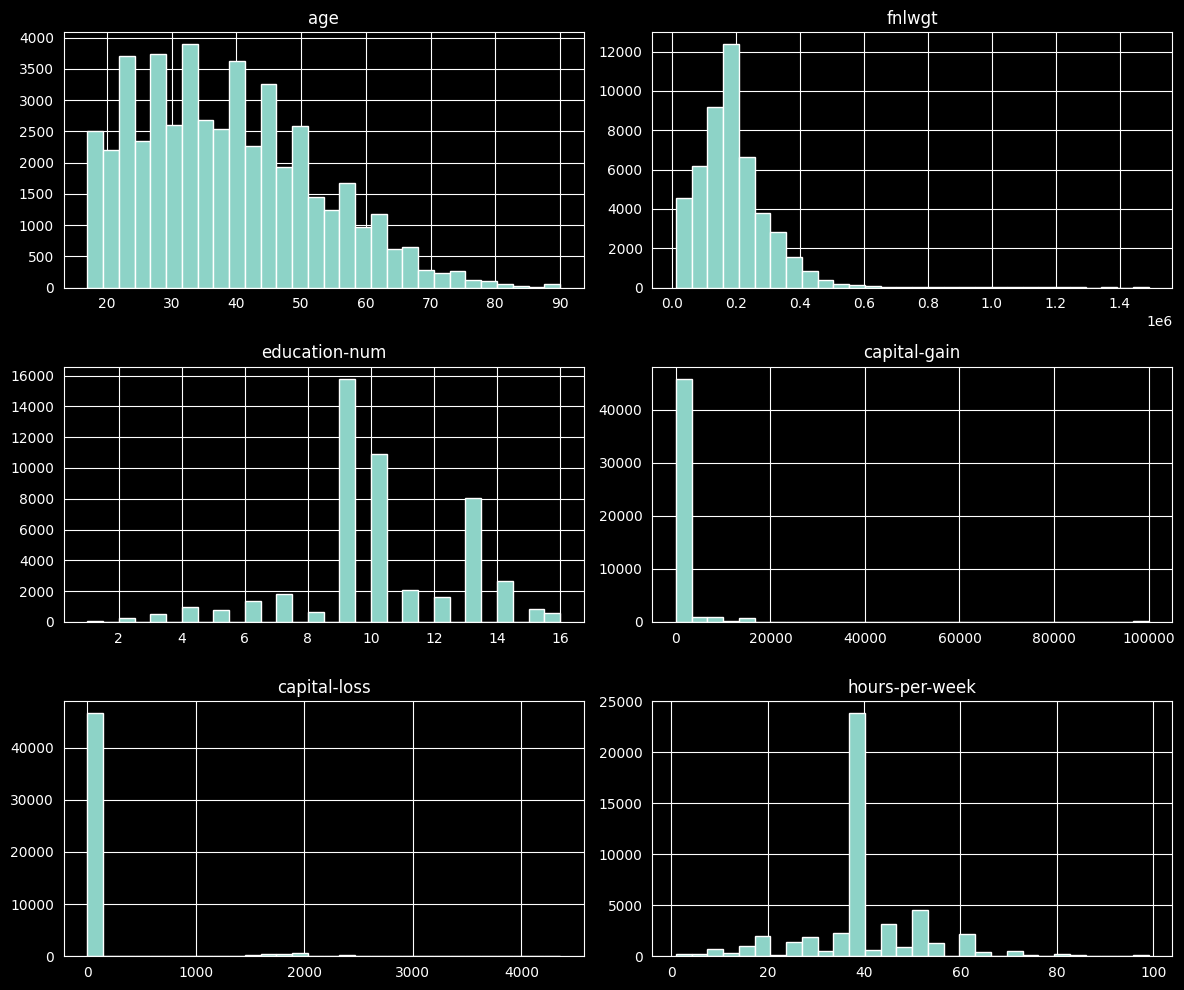

<Figure size 640x480 with 0 Axes>

In [176]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical columns:", num_cols)
df[num_cols].hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()
plt.savefig('results/figures/plot_distribution.png')

### Boxplot of bins
For EDA exploration, to get a better view of the outliers that the boxplot may not portray fully due to specific samples being too infrequent to appear in the boxplot

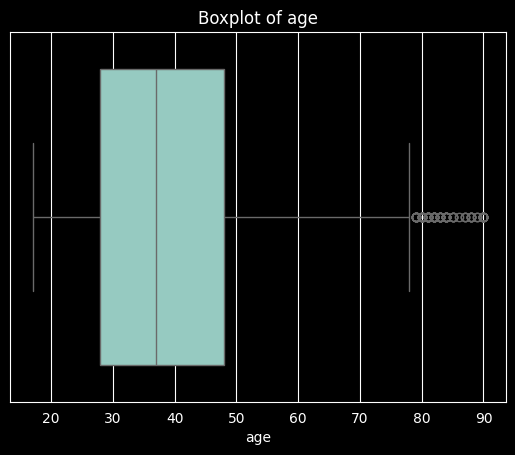

<Figure size 640x480 with 0 Axes>

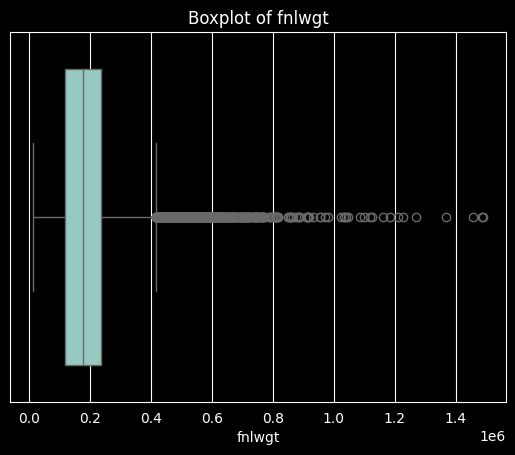

<Figure size 640x480 with 0 Axes>

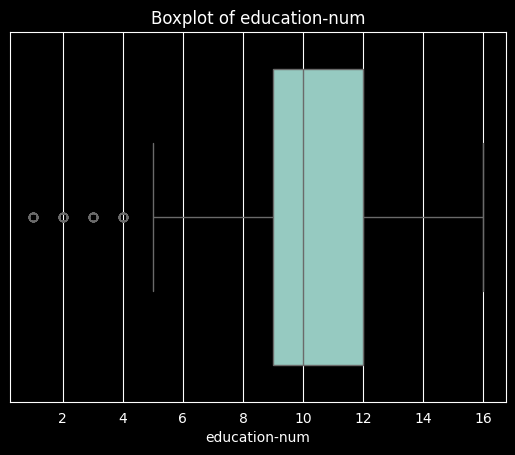

<Figure size 640x480 with 0 Axes>

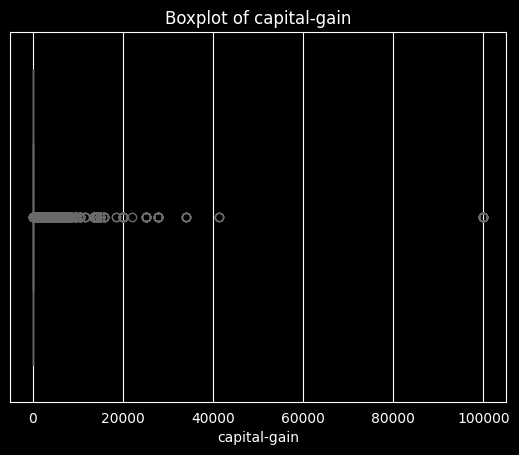

<Figure size 640x480 with 0 Axes>

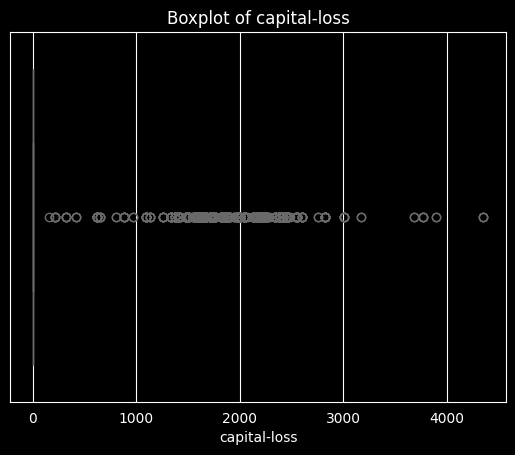

<Figure size 640x480 with 0 Axes>

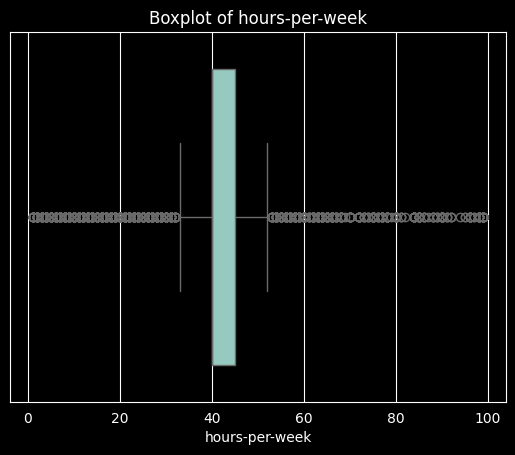

<Figure size 640x480 with 0 Axes>

In [177]:
for idx, col in enumerate(num_cols):
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()
    plt.savefig(f'results/figures/Boxplot_{col}-{idx}.png')


### Categorical Values
Get a sense of the frequency of the categorical values, and the number of unique values in each column.

In [178]:
cat_cols = df.select_dtypes(include='category').columns

for col in cat_cols:
    print(f"{col}: {df[col].nunique()} unique values")

for col in cat_cols:
    print(f"\n{col} value counts:\n{df[col].value_counts()}")


workclass: 8 unique values
education: 16 unique values
marital-status: 7 unique values
occupation: 14 unique values
relationship: 6 unique values
race: 5 unique values
sex: 2 unique values
native-country: 41 unique values
class: 2 unique values

workclass value counts:
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64

education value counts:
education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64

marital-status value counts:
marital-status
Married-civ-spouse       223

### Class Imbalance
The target variable 'income' is imbalanced with a ratio of ~3.1. We will address this soon.

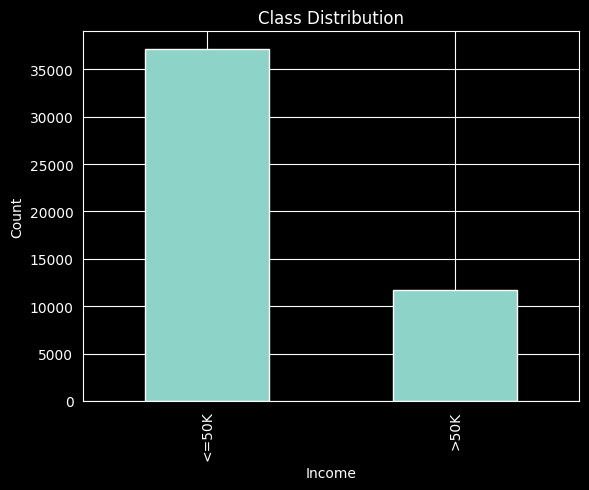

class
<=50K    37155
>50K     11687
Name: count, dtype: int64
Imbalance Ratio: 3.179173440574998


<Figure size 640x480 with 0 Axes>

In [179]:
Y.value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.show()
plt.savefig("results/figures/class_distribution.png")
class_counts = Y.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(class_counts)
print("Imbalance Ratio:", imbalance_ratio)

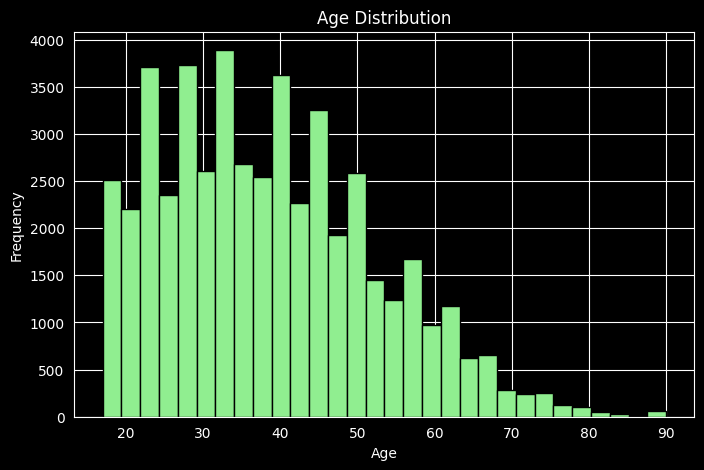

<Figure size 640x480 with 0 Axes>

In [180]:
plt.figure(figsize=(8,5))
plt.hist(df['age'], bins=30, color='lightgreen', edgecolor='black')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()
plt.savefig("results/figures/age_distribution.png")


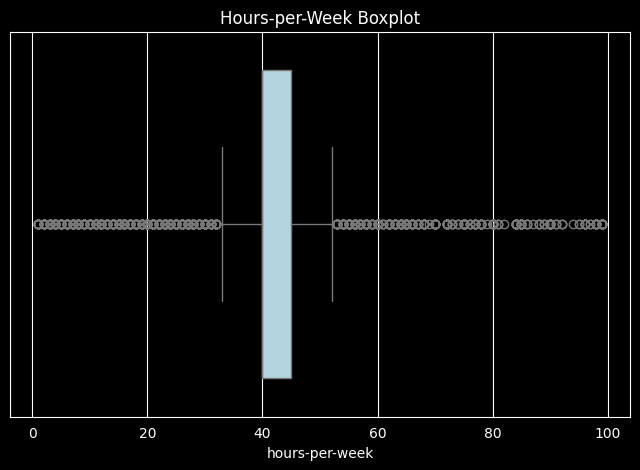

<Figure size 640x480 with 0 Axes>

In [181]:
plt.figure(figsize=(8,5))
sns.boxplot(x=X['hours-per-week'], color='lightblue')
plt.title("Hours-per-Week Boxplot")
plt.show()
plt.savefig("results/figures/hours-per-week-boxplot.png")

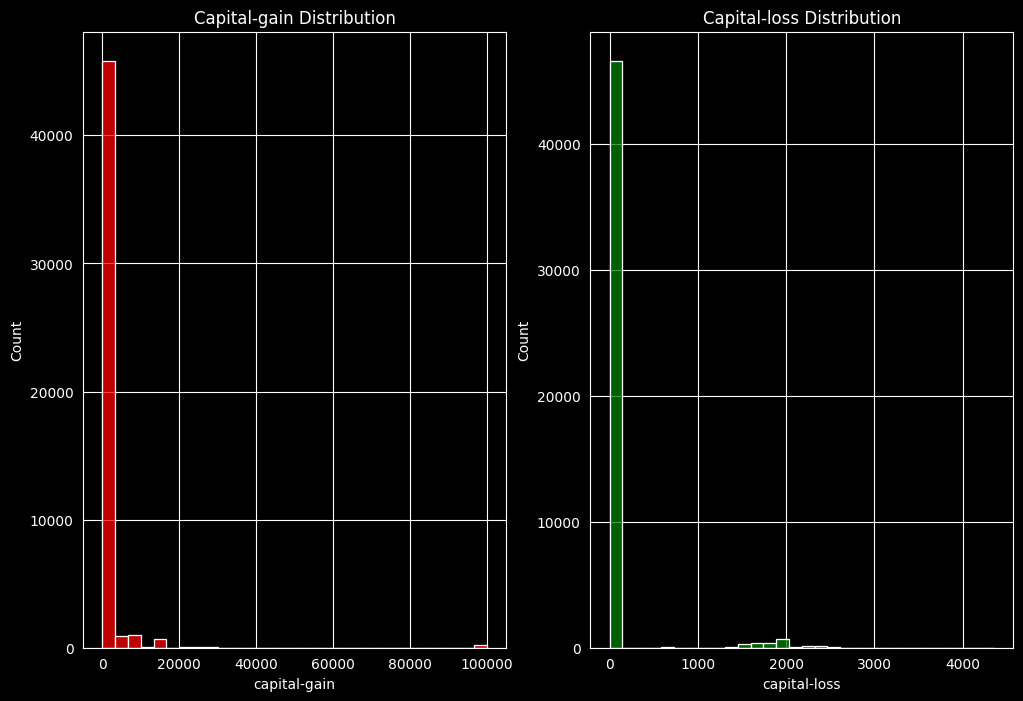

Capital Gain: Min: 0, Max: 99999
Capital Loss: Min: 0, Max: 4356


<Figure size 640x480 with 0 Axes>

In [182]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.histplot(X['capital-gain'], bins=30, color='red', kde=False)
plt.title("Capital-gain Distribution")

plt.subplot(1,2,2)
sns.histplot(X['capital-loss'], bins=30, color='green', kde=False)
plt.title("Capital-loss Distribution")

plt.show()
plt.savefig("results/figures/distributions-2.png")
print(f'Capital Gain: Min: {X['capital-gain'].min()}, Max: {X['capital-gain'].max()}')
print(f'Capital Loss: Min: {X['capital-loss'].min()}, Max: {X['capital-loss'].max()}')

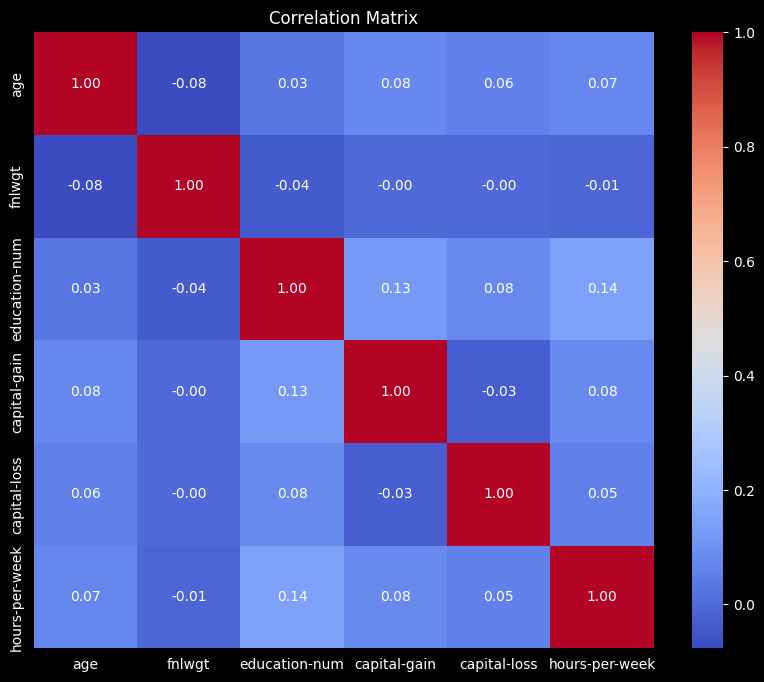

<Figure size 640x480 with 0 Axes>

In [183]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr = df[num_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()
plt.savefig("results/figures/correlation-matrix.png")


### Handling Extreme Outliers
The outliers in capital-gain and capital-loss are extreme, and may skew our later models. I applied log1p (per ChatGPT's suggestion) to these columns instead of dropping them, so we can still maintain the information the extremes had without losing a potential critical datapoint.

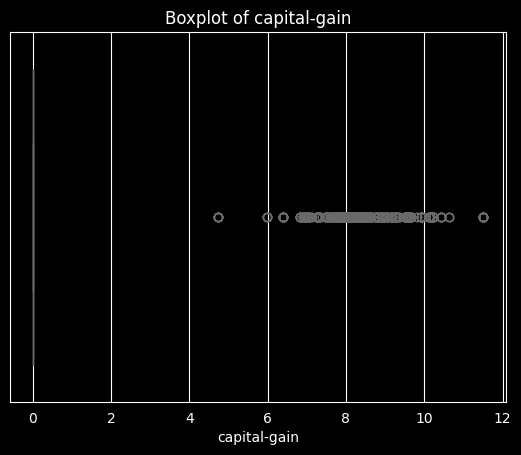

<Figure size 640x480 with 0 Axes>

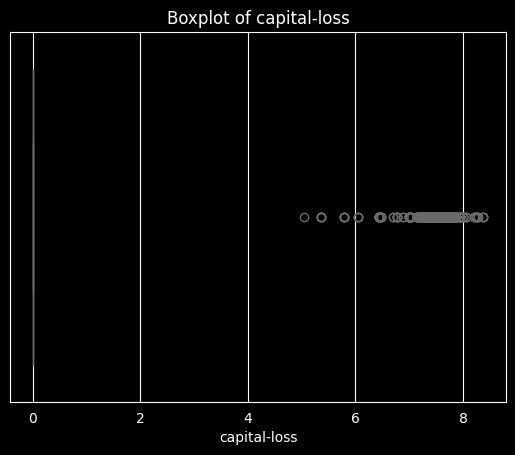

<Figure size 640x480 with 0 Axes>

In [184]:
df['capital-gain'] = np.log1p(df['capital-gain'])
df['capital-loss'] = np.log1p(df['capital-loss'])
# AI DISCLAIMER: log1p suggested by ChatGPT, my initial solution would have been to just drop the extremes.
for idx, col in enumerate(num_cols):
    if col in ['capital-gain', 'capital-loss']:
        plt.figure()
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()
        plt.savefig(f"results/figures/log1p-{col}-{idx}.png")

### Handling Missing Values
As we established earlier, this dataset contains missing values in the 'workclass', 'occupation', and 'native-country' columns. Instead of dropping these rows, we will set the missing values to a new category called 'Unknown'. This way, we can retain all the data while still accounting for the missing information.

In [185]:
is_na_cols = ['workclass', 'occupation', 'native-country']
for col in is_na_cols:
    X[col] = X[col].cat.add_categories('Unknown')
    X[col] = X[col].fillna('Unknown')

### Handling Class Imbalance
The target variable 'income' is imbalanced at a ratio of ~3.1, with a majority of samples in the '<=50K' class. To address this imbalance, I have decided to use Random Over-Sampling, which duplicates samples from the minority class. I chose this method because it preserves the majority class data, is simple to implement, and should effectively balance the class distribution without generating synthetic data that could introduce noise, or removing potentially valuable data from the majority class.

In [186]:
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(
    X, Y,
    test_size=0.2,
    stratify=Y,
    random_state=42,
)
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print("Original class distribution:")
print(y_train.value_counts())
print("\nResampled class distribution:")
print(y_resampled.value_counts())

Original class distribution:
class
<=50K    29724
>50K      9349
Name: count, dtype: int64

Resampled class distribution:
class
<=50K    29724
>50K     29724
Name: count, dtype: int64


## Required Output: Written Justification of preprocessing choices

This is a large dataset, and it requires careful preprocessing to ensure our later machine learning models can learn effectively from the data. After exploring the dataset, I've identified a few preprocessing steps that need to occur.

Firstly, there were missing values in the 'workclass', 'occupation', and 'native-country' columns. Instead of dropping these rows, I chose to create a new category called "Unknown" to fill in these missing values. Since this data likely had some preprocessing before being released, I believe it's likely that the missing values were not random, and instead representative of a specific group of people. By creating a new category, we can retain all the data while still accounting for the missing information.

Next, I dealt with the extreme values in capital-loss and capital-gain by scaling them with a log1p transformation. This allows us to keep the high values (since they likely contain important information) while reducing their skew and influence on models that are sensitive to outliers.

Finally, I addressed the significant class imbalance in the target variable ('income'). For this, I decided to use Random Over-Sampling, which duplicates samples from the minority class. I chose this method because it preserves the majority class data, is simple to implement, and should effectively balance the class distribution without generating synthetic data that could introduce noise, or removing potentially valuable data from the majority class.

#### Finalization of step 1 - Scaling and Encoding

In [187]:
cat_cols = X_resampled.select_dtypes(include='category').columns.tolist()
num_cols = X_resampled.select_dtypes(include=['int64','float64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='warn'), cat_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_resampled)
X_test_processed = preprocessor.transform(X_test)

In [188]:
# Recover train_test_split
X_train = X_train_processed
X_test = X_test_processed
y_train = y_resampled
y_test = y_test

# Part 2 - Baseline Model

In [189]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix
)
from sklearn.model_selection import GridSearchCV
import pandas as pd
import time

def evaluate_model(model_name : str, model, flag_override_training_time=False):
    """
    Helper function for models.
    :param flag_override_training_time: Option to override training time. False = Don't, float = New Value
    :param model_name: string name of the model, for logging purposes.
    :param model: Model raw object, not fitted yet. Will be fitted in this function.
    :return: Dictionary addition for the classification_logs list.
    """
    best_hyperparameters = None
    best_cv_score = None
    start_time = time.time()
    if isinstance(model, GridSearchCV):
        model.fit(X_train, y_train)
        fitted_model = model.best_estimator_
        best_hyperparameters = model.best_params_
        best_cv_score = model.best_score_
    else:
        model.fit(X_train, y_train)
        fitted_model = model

    training_time = time.time() - start_time

    if flag_override_training_time:
        training_time = flag_override_training_time

    y_train_pred = fitted_model.predict(X_train)
    y_test_pred = fitted_model.predict(X_test)

    # Probabilities for AUC, recommended by ChatGPT
    if hasattr(fitted_model, "predict_proba"):
        y_test_proba = fitted_model.predict_proba(X_test)[:, 1]
    elif hasattr(fitted_model, "decision_function"):
        y_test_proba = fitted_model.decision_function(X_test)
    else:
        y_test_proba = None

    # Metrics
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)

    precision_per_class = precision_score(y_test, y_test_pred, average=None, labels=['<=50K','>50K'])
    recall_per_class = recall_score(y_test, y_test_pred, average=None, labels=['<=50K','>50K'])
    f1_per_class = f1_score(y_test, y_test_pred, average=None, labels=['<=50K','>50K'])

    precision_macro = precision_score(y_test, y_test_pred, average='macro')
    precision_weighted = precision_score(y_test, y_test_pred, average='weighted')
    recall_macro = recall_score(y_test, y_test_pred, average='macro')
    recall_weighted = recall_score(y_test, y_test_pred, average='weighted')
    f1_macro = f1_score(y_test, y_test_pred, average='macro')
    f1_weighted = f1_score(y_test, y_test_pred, average='weighted')

    auc_roc = roc_auc_score(y_test.map({'<=50K':0,'>50K':1}), y_test_proba) if y_test_proba is not None else None
    auc_pr = average_precision_score(y_test.map({'<=50K':0,'>50K':1}), y_test_proba) if y_test_proba is not None else None

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=['<=50K','>50K'])
    TN, FP = cm[0]
    FN, TP = cm[1]

    log_entry = {
        'Model': model_name,
        'Training Accuracy': acc_train,
        'Test Accuracy': acc_test,
        'Precision <=50K': precision_per_class[0],
        'Precision >50K': precision_per_class[1],
        'Precision Macro': precision_macro,
        'Precision Weighted': precision_weighted,
        'Recall <=50K': recall_per_class[0],
        'Recall >50K': recall_per_class[1],
        'Recall Macro': recall_macro,
        'Recall Weighted': recall_weighted,
        'F1 <=50K': f1_per_class[0],
        'F1 >50K': f1_per_class[1],
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr,
        'Training Time (s)': training_time,
        'False Positives': int(FP),
        'False Negatives': int(FN),
        # Data for later use in ROC curve and classification report
        'Confusion Matrix': cm,
        'y_test': y_test,
        'y_test_proba': y_test_proba,
        'fitted_model': fitted_model,
        'Classification Report': classification_report(y_test, y_test_pred, target_names=['<=50K','>50K'],
                                                       output_dict=True),
        'Best Hyperparameters': best_hyperparameters,
        'Best CV Score': best_cv_score
    }

    classification_logs.append(log_entry)
    return log_entry

In [190]:
classification_logs = []
def print_log(log):
    print(f"""
Model: {log['Model']}
Training Accuracy: {log['Training Accuracy']:.4f}
Test Accuracy: {log['Test Accuracy']:.4f}
AUC-ROC: {log['AUC-ROC']:.4f}
False Positives: {log['False Positives']}
False Negatives: {log['False Negatives']}
""")
def compare_models(model_one: str, model_two: str):
    """
    AI Disclaimer: Generated with ChatGPT, based on my self coded evaluate model function.
    :param model_one: Name of the first model.
    :param model_two: Name of the second model.
    :return:
    """
    lower_is_better = ['Training Time (s)', 'False Positives', 'False Negatives']
    ignore_keys = ['Model', 'Confusion Matrix', 'y_test', 'y_test_proba', 'Classification Report', 'fitted_model','Best Hyperparameters','Best CV Score']

    local_m1 = None
    local_m2 = None
    local_results = []

    # Find the two models in logs
    for item in classification_logs:
        if item['Model'] == model_one:
            local_m1 = item
        if item['Model'] == model_two:
            local_m2 = item
        if local_m1 and local_m2:
            break

    if not local_m1 or not local_m2:
        print(f"One or both models not found: {model_one}, {model_two}")
        return None

    # Compare metrics
    for key in local_m1.keys():
        if key in ignore_keys:
            continue

        val1 = local_m1.get(key)
        val2 = local_m2.get(key)

        # Skip metrics that are None
        if val1 is None or val2 is None:
            winner = None
        else:
            if key in lower_is_better:
                winner = model_one if val1 < val2 else model_two
            else:
                winner = model_one if val1 > val2 else model_two

        local_results.append({
            'Metric': key,
            model_one: val1,
            model_two: val2,
            'Winner': winner
        })

    return pd.DataFrame(local_results)

def display_roc_curve(log_entry):
    '''
    # ROC Curve
    # AI DISCLAIMER: Graph generated by ChatGPT
    :param log_entry dict returned by evaluate_model()
    '''
    # Check required keys
    if 'y_test_proba' not in log_entry or log_entry['y_test_proba'] is None:
        print(f"No probability predictions available for {log_entry['Model']}. Cannot plot ROC.")
        return

    l_y_test = log_entry['y_test']
    l_y_test_proba = log_entry['y_test_proba']
    model_name = log_entry['Model']

    fpr, tpr, thresholds = roc_curve(l_y_test, l_y_test_proba, pos_label='>50K')
    l_roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {l_roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.savefig(f"results/figures/{model_name}-roc-curve.png")

def best_models_table_by_metric():
    """
    Rank models by weighted metric wins.
    Each metric gives its weight in points to the best model.
    """

    if not classification_logs:
        print("No models in logs.")
        return pd.DataFrame()

    lower_is_better = ['Training Time (s)', 'False Positives', 'False Negatives']
    ignore_keys = ['Model', 'Confusion Matrix', 'y_test',
                   'y_test_proba', 'Classification Report', 'fitted_model', 'Best Hyperparameters','Best CV Score']

    weights = {
        'F1 >50K': 5,
        'Recall >50K': 3,
        'Precision >50K': 2,
        'AUC-PR': 3,
        'AUC-ROC': 2,
        'F1 Macro': 1,
        'F1 Weighted': 1,
        'Test Accuracy': 1,
        'False Negatives': 3,
        'False Positives': 1,
        'Training Time (s)': 1
    }

    # Initialize scores
    model_scores = {log['Model']: 0 for log in classification_logs}

    # Get relevant metrics
    metrics = [k for k in classification_logs[0].keys()
               if k not in ignore_keys and k in weights]

    # Compare each metric
    for metric in metrics:

        values = {
            log['Model']: log[metric]
            for log in classification_logs
            if log[metric] is not None
        }

        if not values:
            continue

        # Determine best value
        if metric in lower_is_better:
            best_value = min(values.values())
        else:
            best_value = max(values.values())

        # Add weight to winner(s)
        for model_name, val in values.items():
            if val == best_value:
                model_scores[model_name] += weights[metric]

    # Sort descending
    sorted_models = sorted(model_scores.items(),
                           key=lambda x: x[1],
                           reverse=True)

    return pd.DataFrame(sorted_models, columns=["Model", "Weighted Points"])


In [191]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay)

In [192]:
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

data = evaluate_model("Logistic Regression", logistic_regression)

print(f"Training Accuracy: {data['Training Accuracy']:.4f}")
print(f"Test Accuracy: {data['Test Accuracy']:.4f}")
compare_models("Logistic Regression", "Logistic Regression") # For Printing

Training Accuracy: 0.8248
Test Accuracy: 0.8093


,Metric,Logistic Regression,Winner
0,Training Accuracy,0.824805,Logistic Regression
1,Test Accuracy,0.809295,Logistic Regression
2,Precision <=50K,0.940785,Logistic Regression
3,Precision >50K,0.568781,Logistic Regression
4,Precision Macro,0.754783,Logistic Regression
5,Precision Weighted,0.851754,Logistic Regression
6,Recall <=50K,0.799623,Logistic Regression
7,Recall >50K,0.840034,Logistic Regression
8,Recall Macro,0.819829,Logistic Regression
9,Recall Weighted,0.809295,Logistic Regression


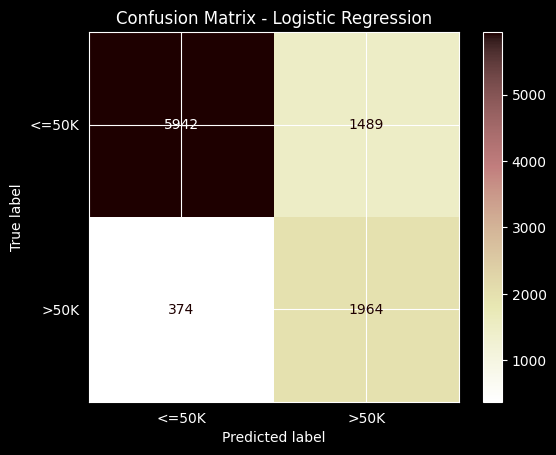

<Figure size 640x480 with 0 Axes>

In [193]:
# Confusion Matrix Visualization
TN, FP = data['Confusion Matrix'][0]
FN, TP = data['Confusion Matrix'][1]
disp = ConfusionMatrixDisplay(confusion_matrix=data['Confusion Matrix'], display_labels=logistic_regression.classes_)
disp.plot(cmap='pink_r')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()
plt.savefig("results/figures/confusion-matix-regression.png")

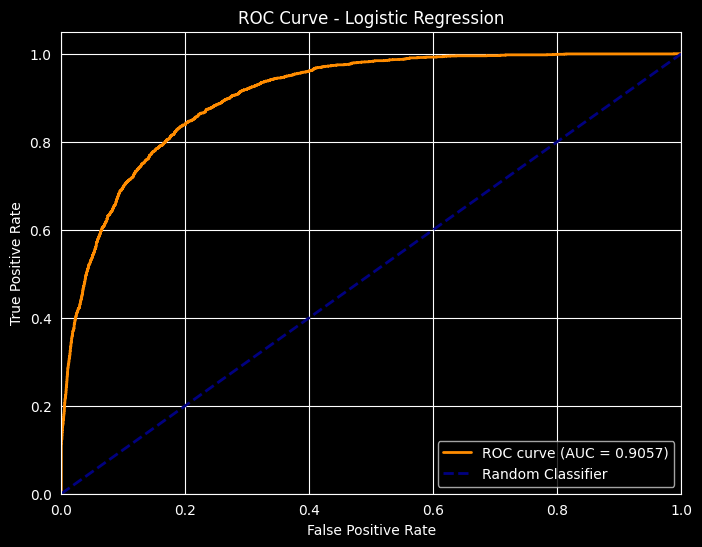

<Figure size 640x480 with 0 Axes>

In [194]:
display_roc_curve(data)

In [195]:
print_log(data)


Model: Logistic Regression
Training Accuracy: 0.8248
Test Accuracy: 0.8093
AUC-ROC: 0.9057
False Positives: 1489
False Negatives: 374



### Brief analysis of baseline performance
The linear regression model did surprisingly well, achieving a test accuracy of 0.80 and an AUC of 0.90, which is great for a baseline model. Test Accuracy was near Training Accuracy, indicating no significant overfitting. The Confusion Matrix shows the model had a bigger issue with false positives than false negatives.

# Part 3 - Advanced Models

### Model 1: Random Forest Classifier

In [196]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


In [197]:
rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
)

data = evaluate_model("Random Forest", rf)


#### Random Forest: Important Features
Random Forest considered 'age', 'fnlwgt', and marital-status as the most important features, while 'relationship-unmarried' and 'workclass-Private' were the least important. This suggests that age and marital status may be strong indicators of income level in this dataset, while relationship status and workclass are not influential.

In [198]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.Series(
    rf.feature_importances_,
    index=feature_names,
).sort_values(ascending=False)

print(feature_importance.head(20))

num__age                                  0.158652
num__fnlwgt                               0.145188
cat__marital-status_Married-civ-spouse    0.100777
num__hours-per-week                       0.076942
num__capital-gain                         0.064853
num__education-num                        0.058961
cat__relationship_Husband                 0.047172
cat__marital-status_Never-married         0.029756
num__capital-loss                         0.021791
cat__relationship_Not-in-family           0.019108
cat__relationship_Own-child               0.015027
cat__occupation_Exec-managerial           0.014586
cat__occupation_Prof-specialty            0.014050
cat__relationship_Wife                    0.012396
cat__sex_Female                           0.011844
cat__occupation_Other-service             0.011455
cat__education_Bachelors                  0.011053
cat__sex_Male                             0.010695
cat__workclass_Private                    0.008884
cat__relationship_Unmarried    

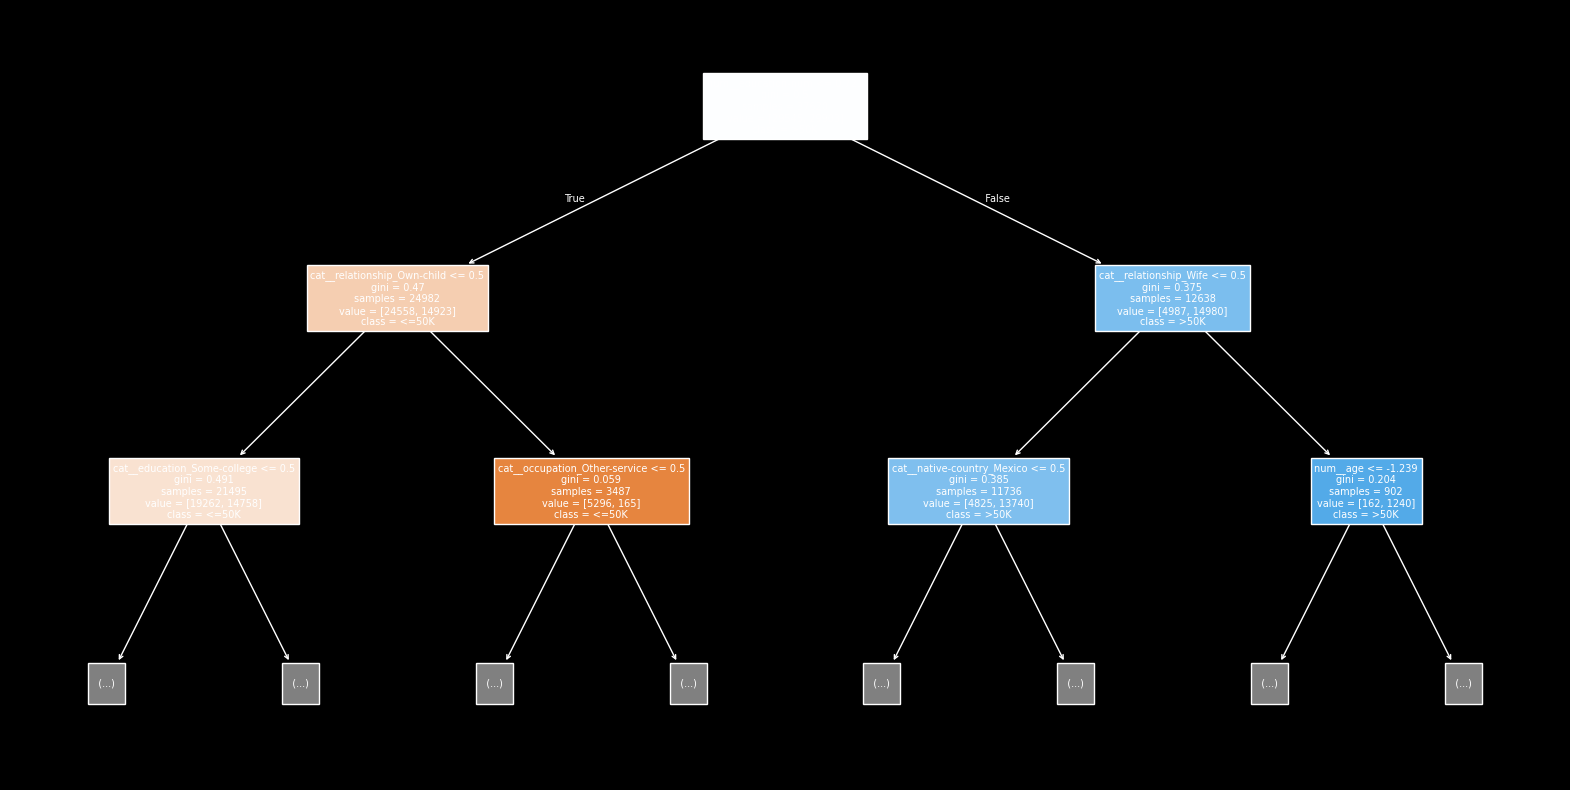

<Figure size 640x480 with 0 Axes>

In [199]:
from sklearn.tree import plot_tree

tree = rf.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=rf.classes_,
    filled=True,
    max_depth=2,
)
plt.show()
plt.savefig("results/figures/tree1.png")

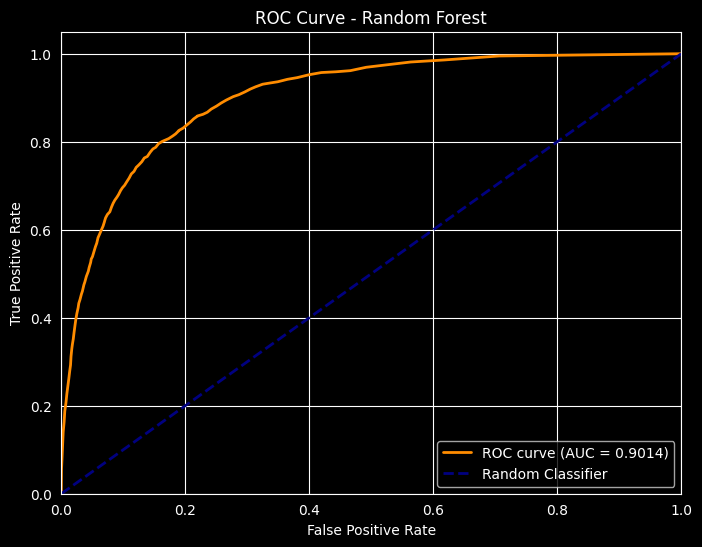

<Figure size 640x480 with 0 Axes>

In [200]:
display_roc_curve(data)


In [201]:
print_log(data)
compare_models('Logistic Regression', 'Random Forest')


Model: Random Forest
Training Accuracy: 0.9999
Test Accuracy: 0.8521
AUC-ROC: 0.9014
False Positives: 733
False Negatives: 712



,Metric,Logistic Regression,Random Forest,Winner
0,Training Accuracy,0.824805,0.999950,Random Forest
1,Test Accuracy,0.809295,0.852083,Random Forest
2,Precision <=50K,0.940785,0.903914,Logistic Regression
3,Precision >50K,0.568781,0.689275,Random Forest
4,Precision Macro,0.754783,0.796594,Random Forest
5,Precision Weighted,0.851754,0.852545,Random Forest
6,Recall <=50K,0.799623,0.901359,Random Forest
7,Recall >50K,0.840034,0.695466,Logistic Regression
8,Recall Macro,0.819829,0.798413,Logistic Regression
9,Recall Weighted,0.809295,0.852083,Random Forest


In [202]:
importances = rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importances": importances,
}).sort_values(by='Importances', ascending=False)

print(feature_importance_df.head(20))

                                   Feature  Importances
0                                 num__age     0.158652
1                              num__fnlwgt     0.145188
33  cat__marital-status_Married-civ-spouse     0.100777
5                      num__hours-per-week     0.076942
3                        num__capital-gain     0.064853
2                       num__education-num     0.058961
53               cat__relationship_Husband     0.047172
35       cat__marital-status_Never-married     0.029756
4                        num__capital-loss     0.021791
54         cat__relationship_Not-in-family     0.019108
56             cat__relationship_Own-child     0.015027
41         cat__occupation_Exec-managerial     0.014586
47          cat__occupation_Prof-specialty     0.014050
58                  cat__relationship_Wife     0.012396
64                         cat__sex_Female     0.011844
45           cat__occupation_Other-service     0.011455
24                cat__education_Bachelors     0

#### Random Forest: Review
When ran with default hyperparameters, the Random Forest model began to overfit, achieving a training accuracy of nearly 100% but a testing accuracy of 0.85. This was likely due to unlimited tree depth. AUC was virtually identical between the baseline model and Random Forest, and the confusion matrix shows a significant reduction in false positives, but a slight increase in false negatives. Overall, Random Forest would be ideal here if we were optimizing for false positives and needed a more balanced model.

### Model 2: Decision Tree Classifier

In [203]:
from sklearn.tree import DecisionTreeClassifier

In [204]:
dt = DecisionTreeClassifier(
    random_state=42,
)

data = evaluate_model("Decision Tree", dt)



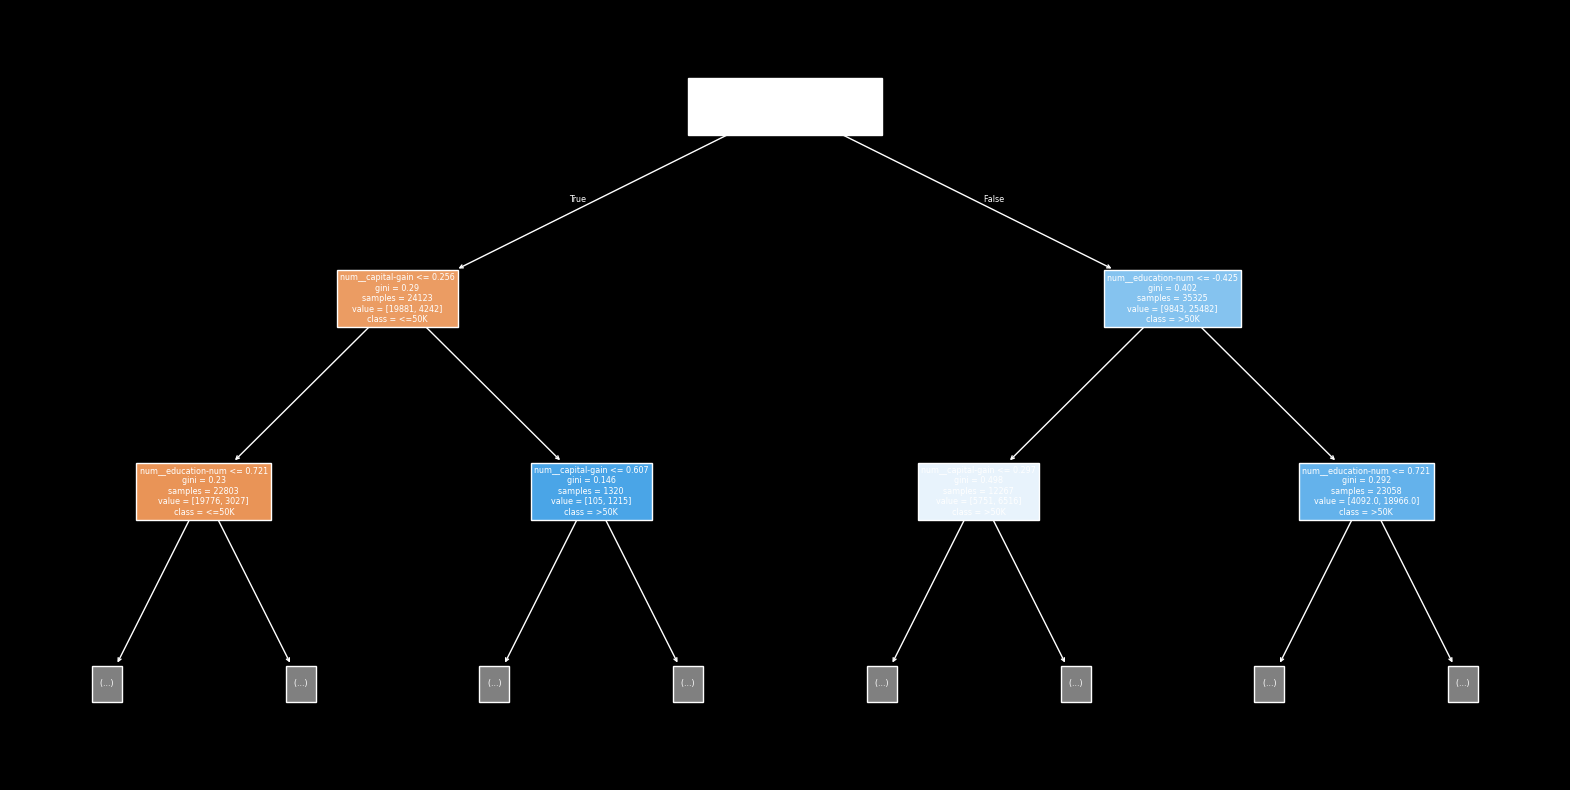

<Figure size 640x480 with 0 Axes>

In [205]:
feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(20,10))
plot_tree(
    dt,
    feature_names=feature_names,
    class_names=['<=50K', '>50K'],
    filled=True,
    max_depth=2
)
plt.show()
plt.savefig("results/figures/tree2.png")

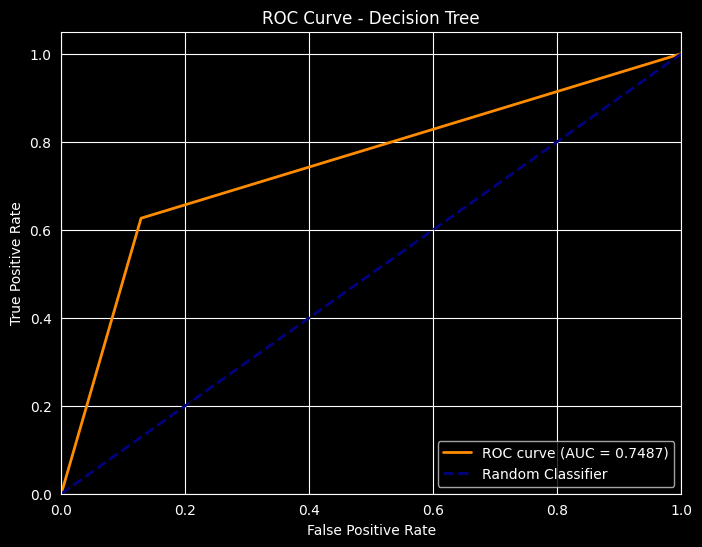

<Figure size 640x480 with 0 Axes>

In [206]:
display_roc_curve(data)

#### Decision Tree: Important Features
Like Random Forest, age, fnlwgt, and marital-status were the most important features. Unlike Random Forest however, the lowest values were instead native country-United-States and Occupation.

In [207]:
feature_names = preprocessor.get_feature_names_out()

dt_feature_importance = pd.Series(
    dt.feature_importances_,
    index=feature_names
).sort_values(ascending=False)

print(dt_feature_importance.head(20))


cat__marital-status_Married-civ-spouse    0.287042
num__fnlwgt                               0.158208
num__age                                  0.107011
num__education-num                        0.097496
num__capital-gain                         0.089438
num__hours-per-week                       0.064826
num__capital-loss                         0.028074
cat__workclass_Private                    0.009502
cat__occupation_Exec-managerial           0.008266
cat__occupation_Craft-repair              0.008244
cat__occupation_Sales                     0.007214
cat__workclass_Self-emp-not-inc           0.006814
cat__race_White                           0.006493
cat__occupation_Prof-specialty            0.006327
cat__occupation_Transport-moving          0.005177
cat__occupation_Other-service             0.004929
cat__occupation_Adm-clerical              0.004733
cat__workclass_Local-gov                  0.004264
cat__occupation_Machine-op-inspct         0.004219
cat__native-country_United-Stat

In [208]:
print_log(data)
compare_models('Logistic Regression', 'Decision Tree')


Model: Decision Tree
Training Accuracy: 1.0000
Test Accuracy: 0.8126
AUC-ROC: 0.7487
False Positives: 957
False Negatives: 874



,Metric,Logistic Regression,Decision Tree,Winner
0,Training Accuracy,0.824805,0.999966,Decision Tree
1,Test Accuracy,0.809295,0.812570,Decision Tree
2,Precision <=50K,0.940785,0.881056,Logistic Regression
3,Precision >50K,0.568781,0.604709,Decision Tree
4,Precision Macro,0.754783,0.742882,Logistic Regression
5,Precision Weighted,0.851754,0.814918,Logistic Regression
6,Recall <=50K,0.799623,0.871215,Decision Tree
7,Recall >50K,0.840034,0.626176,Logistic Regression
8,Recall Macro,0.819829,0.748696,Logistic Regression
9,Recall Weighted,0.809295,0.812570,Decision Tree


#### Decision Tree: Review
When ran with default hyperparameters, Decision trees, like Random Forest, began to overfit. Decision trees also had more incorrect values overall, and just did worse in general (Evident by the low AUC). It's likely that tuning the hyperparameters of the Decision Tree could have improved its performance, but since the assignment mandates defaults, we will not adjust.

### Model 3 - Neural Network Classifier

In [209]:
from sklearn.neural_network import MLPClassifier
def get_cpu_name():
    try:
        with open("/proc/cpuinfo") as f:
            for line in f:
                if line.startswith("model name"):
                    return line.split(":")[1].strip()
    except FileNotFoundError:
        return "Unknown CPU"
print(get_cpu_name())

AMD RYZEN AI MAX+ 395 w/ Radeon 8060S


In [210]:
mlp_time = "UNTESTED"
try:
    with open("mlp_time.txt", "r") as f:
        mlp_time = f.read().strip()
except FileNotFoundError:
    pass
print(f"MLP Classifier with default hyperparameters took {str(mlp_time) or "UNTESTED"} seconds to train on a previous run (With 16c/32t Ryzen AI Max+ 395). This will take some time on low spec hardware!")
mlp = MLPClassifier(
    random_state=42,
    max_iter=1000, # I know we aren't meant to change from defaults, but this is to avoid ConvergenceWarning.
)
data = evaluate_model("MLP Classifier (Neural Network)", mlp)

if "AMD RYZEN AI MAX+ 395" in get_cpu_name():
    with open("mlp_time.txt", "w") as f:
        f.write(str(data['Training Time (s)']))


MLP Classifier with default hyperparameters took 54.10887575149536 seconds to train on a previous run (With 16c/32t Ryzen AI Max+ 395). This will take some time on low spec hardware!


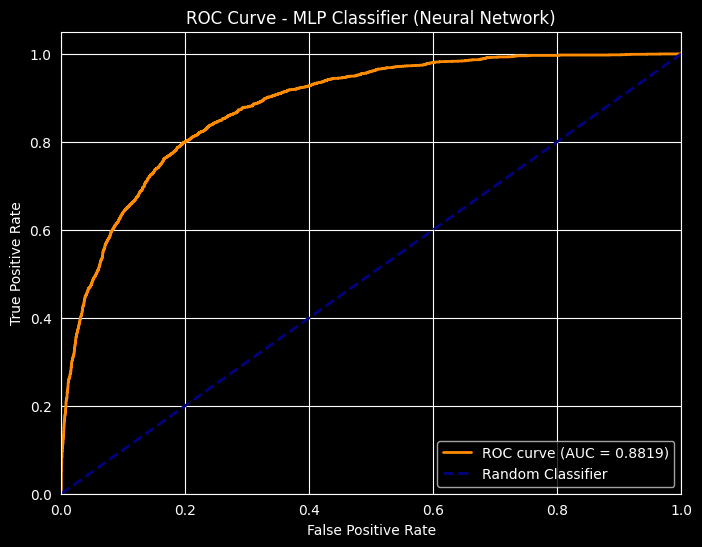

<Figure size 640x480 with 0 Axes>

In [211]:
display_roc_curve(data)

In [212]:
print_log(data)
compare_models('Logistic Regression', 'MLP Classifier (Neural Network)')


Model: MLP Classifier (Neural Network)
Training Accuracy: 0.9042
Test Accuracy: 0.8192
AUC-ROC: 0.8819
False Positives: 1162
False Negatives: 604



,Metric,Logistic Regression,MLP Classifier (Neural Network),Winner
0,Training Accuracy,0.824805,0.904219,MLP Classifier (Neural Network)
1,Test Accuracy,0.809295,0.819224,MLP Classifier (Neural Network)
2,Precision <=50K,0.940785,0.912120,Logistic Regression
3,Precision >50K,0.568781,0.598757,MLP Classifier (Neural Network)
4,Precision Macro,0.754783,0.755438,MLP Classifier (Neural Network)
5,Precision Weighted,0.851754,0.837123,Logistic Regression
6,Recall <=50K,0.799623,0.843628,MLP Classifier (Neural Network)
7,Recall >50K,0.840034,0.741660,Logistic Regression
8,Recall Macro,0.819829,0.792644,Logistic Regression
9,Recall Weighted,0.809295,0.819224,MLP Classifier (Neural Network)


#### Neural Network: Review
When ran with default hyperparameters, Neural Networks performed similarly to Logistic Regression, trading advantages across a few evaluation metrics. While it achieved slightly higher test accuracy, it produced lower AUC scores, indicating weaker overall class separability across thresholds.

Additionally, the Neural Network required significantly higher training time, representing a substantial increase in computational cost. Given that performance gains were marginal and not consistent across all key metrics, Logistic Regression demonstrated superior efficiency.

Tuning of the Neural Network's hyperparameters may have improved its performance, but since the assignment mandates defaults, we will not adjust.

### Model 4 - LinearSVC

In [213]:
from sklearn.svm import LinearSVC

In [214]:
hg = LinearSVC(random_state=42,)
data = evaluate_model("LinearSVC", hg)

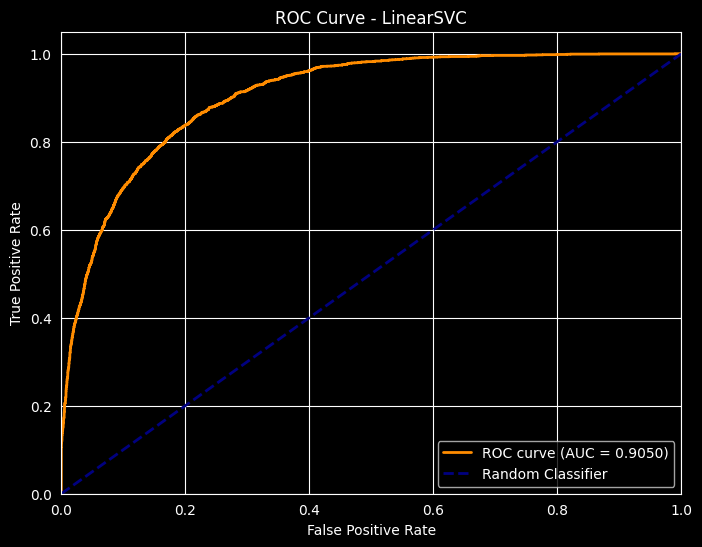

<Figure size 640x480 with 0 Axes>

In [215]:
display_roc_curve(data)

In [216]:
feature_names = preprocessor.get_feature_names_out()
feature_importance = np.abs(hg.coef_[0])
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": feature_importance
}).sort_values(by="importance", ascending=False)

print(importance_df.head(20))

                                    feature  importance
3                         num__capital-gain    0.998016
69             cat__native-country_Columbia    0.712943
92            cat__native-country_Nicaragua    0.712311
46          cat__occupation_Priv-house-serv    0.654208
81             cat__native-country_Honduras    0.523136
32    cat__marital-status_Married-AF-spouse    0.497658
33   cat__marital-status_Married-civ-spouse    0.496459
103     cat__native-country_Trinadad&Tobago    0.485843
71   cat__native-country_Dominican-Republic    0.484933
86              cat__native-country_Ireland    0.484349
107          cat__native-country_Yugoslavia    0.410156
75               cat__native-country_France    0.409198
35        cat__marital-status_Never-married    0.391111
8               cat__workclass_Never-worked    0.374046
74              cat__native-country_England    0.373400
58                   cat__relationship_Wife    0.369135
79                cat__native-country_Haiti    0

In [217]:
print_log(data)
compare_models('Logistic Regression', 'LinearSVC')


Model: LinearSVC
Training Accuracy: 0.8243
Test Accuracy: 0.8026
AUC-ROC: 0.9050
False Positives: 1584
False Negatives: 344



,Metric,Logistic Regression,LinearSVC,Winner
0,Training Accuracy,0.824805,0.824283,Logistic Regression
1,Test Accuracy,0.809295,0.802641,Logistic Regression
2,Precision <=50K,0.940785,0.944435,LinearSVC
3,Precision >50K,0.568781,0.557295,Logistic Regression
4,Precision Macro,0.754783,0.750865,Logistic Regression
5,Precision Weighted,0.851754,0.851782,LinearSVC
6,Recall <=50K,0.799623,0.786839,Logistic Regression
7,Recall >50K,0.840034,0.852866,LinearSVC
8,Recall Macro,0.819829,0.819852,LinearSVC
9,Recall Weighted,0.809295,0.802641,Logistic Regression


#### LinearSVC: Review
When ran with default hyperparameters, LinearSVC did pretty well, but overall wasn't significantly better or worse than linear regression. It had worse training and testing accuracy, but better precision for <=50K and better recall for >50K. AUC was slightly worse, but really not by much. Given the similar performance, it's really a tie on which model is better, but I would give a slight edge to Logistic Regression due to its better AUC and slightly better overall balance of precision and recall across classes.

# Part 4: Create Comparison Visualization

In [218]:
def plot_by_metrics(metrics_to_plot: list[str]=None):

    if metrics_to_plot is None:
        metrics_to_plot = ['False Positives', 'False Negatives']
    models = [log["Model"] for log in classification_logs]

    x = np.arange(len(models))
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(metrics_to_plot):
        values = [log[metric] for log in classification_logs]
        plt.bar(x + i*0.2, values, width=0.2, label=metric)

    plt.xticks(x + 0.2*(len(metrics_to_plot)-1)/2, models)
    plt.ylabel("Score")
    plt.title("Model Comparison: False/True Positives/Negatives")
    plt.legend()
    plt.show()
    plt.savefig(f"results/figures/{metrics_to_plot[0]}-{metrics_to_plot[1]}.png")

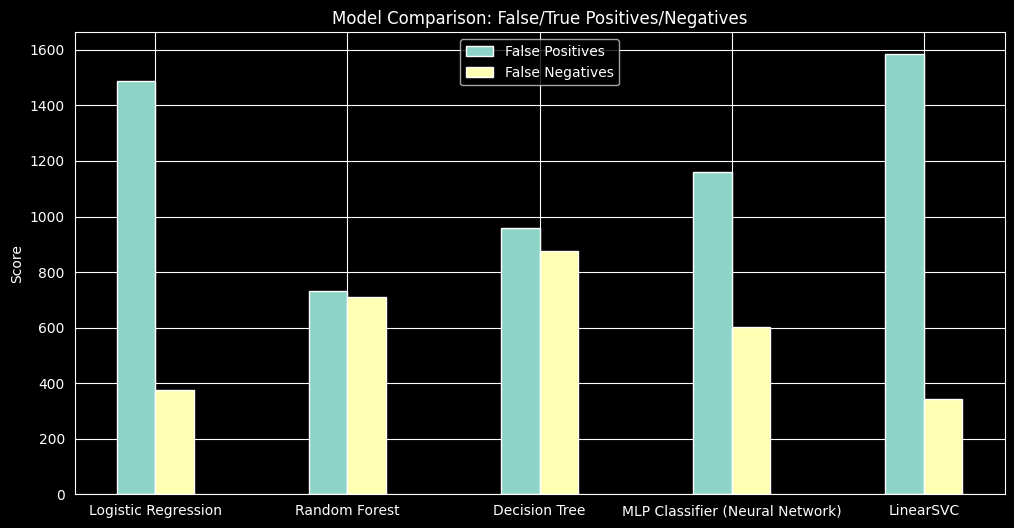

<Figure size 640x480 with 0 Axes>

In [219]:
plot_by_metrics(["False Positives", "False Negatives"])

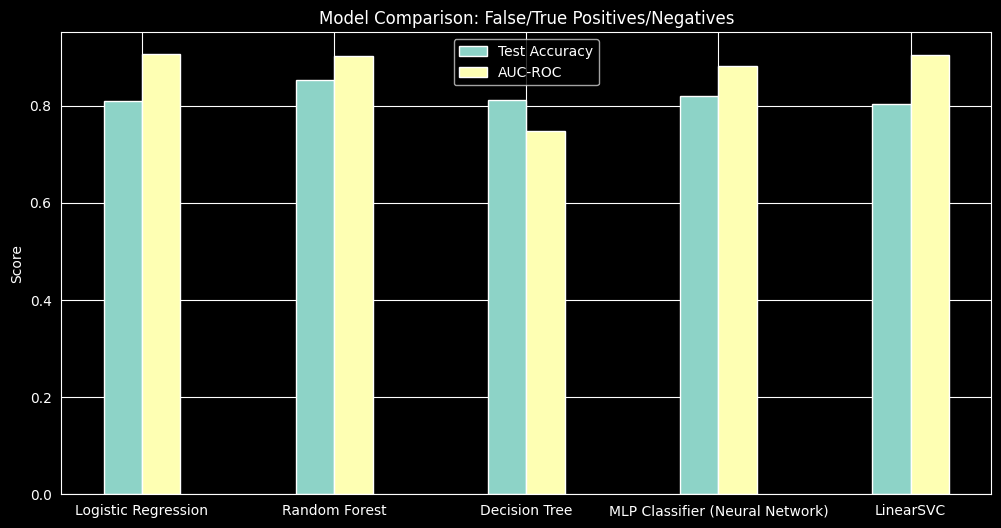

<Figure size 640x480 with 0 Axes>

In [220]:
plot_by_metrics(['Test Accuracy', 'AUC-ROC'])

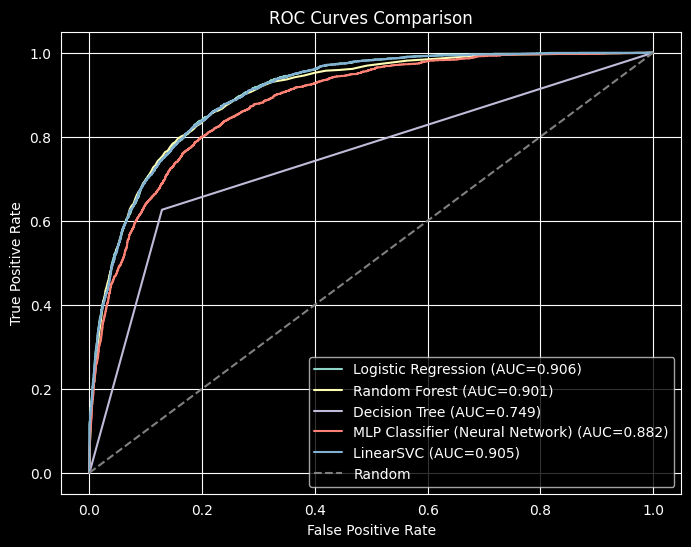

<Figure size 640x480 with 0 Axes>

In [221]:
#AI DISCLAIMER: AI Assisted.
plt.figure(figsize=(8,6))
for log in classification_logs:
    fpr, tpr, _ = roc_curve(log['y_test'], log['y_test_proba'], pos_label='>50K')
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{log['Model']} (AUC={roc_auc:.3f})")

plt.plot([0,1],[0,1],color='gray', linestyle='--',label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()
plt.savefig("results/figures/ROC-curves.png")

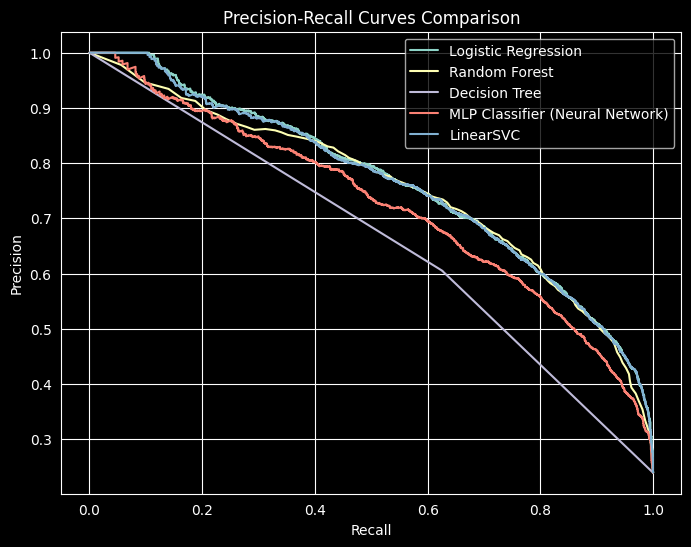

<Figure size 640x480 with 0 Axes>

In [222]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
plt.figure(figsize=(8,6))
for log in classification_logs:
    precision, recall, _ = precision_recall_curve(log['y_test'], log['y_test_proba'], pos_label='>50K')
    plt.plot(recall, precision, label=f"{log['Model']}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves Comparison")
plt.legend()
plt.show()
plt.savefig("results/figures/recall-curves.png")

In [223]:
best = best_models_table_by_metric()['Model']
print("Best Model:", best[0], "with", best_models_table_by_metric()['Weighted Points'][0], "points")
compare_models(best[0], "Logistic Regression")

Best Model: Random Forest with 11 points


,Metric,Random Forest,Logistic Regression,Winner
0,Training Accuracy,0.999950,0.824805,Random Forest
1,Test Accuracy,0.852083,0.809295,Random Forest
2,Precision <=50K,0.903914,0.940785,Logistic Regression
3,Precision >50K,0.689275,0.568781,Random Forest
4,Precision Macro,0.796594,0.754783,Random Forest
5,Precision Weighted,0.852545,0.851754,Random Forest
6,Recall <=50K,0.901359,0.799623,Random Forest
7,Recall >50K,0.695466,0.840034,Logistic Regression
8,Recall Macro,0.798413,0.819829,Logistic Regression
9,Recall Weighted,0.852083,0.809295,Random Forest


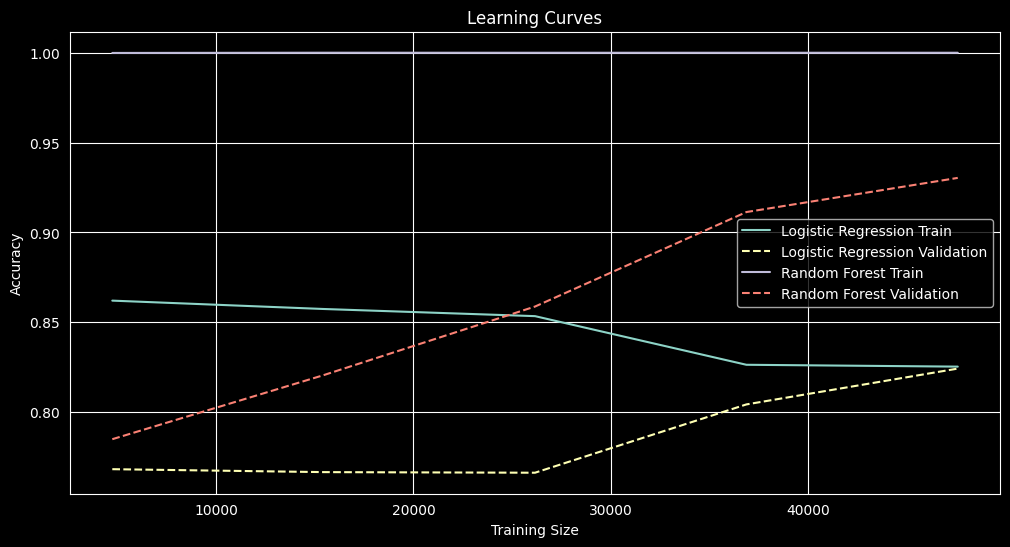

<Figure size 640x480 with 0 Axes>

In [224]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
plt.figure(figsize=(12,6))

best_models = [best[0], best[1]]
best_raw = [log for log in classification_logs if log['Model'] in best_models]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Prevent ValueError
for log in best_raw:
    model_obj = log['fitted_model']
    train_sizes, train_scores, val_scores = learning_curve(model_obj, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label=f"{log['Model']} Train")
    plt.plot(train_sizes, np.mean(val_scores, axis=1), label=f"{log['Model']} Validation", linestyle='--')
plt.xlabel("Training Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves")
plt.legend()
plt.show()
plt.savefig("results/figures/learning-curves.png")

In [225]:
for model in classification_logs:
    print(f"""
Model: {model['Model']}
F1 Score: {model["F1 Macro"]:.3f}
AUC-ROC: {model['AUC-ROC']:.3f}
Recall for >50K: {model['Recall >50K']:.3f}
Training Time: {model['Training Time (s)']:.3f} seconds
""")


Model: Logistic Regression
F1 Score: 0.771
AUC-ROC: 0.906
Recall for >50K: 0.840
Training Time: 0.157 seconds


Model: Random Forest
F1 Score: 0.797
AUC-ROC: 0.901
Recall for >50K: 0.695
Training Time: 1.575 seconds


Model: Decision Tree
F1 Score: 0.746
AUC-ROC: 0.749
Recall for >50K: 0.626
Training Time: 1.490 seconds


Model: MLP Classifier (Neural Network)
F1 Score: 0.770
AUC-ROC: 0.882
Recall for >50K: 0.742
Training Time: 88.694 seconds


Model: LinearSVC
F1 Score: 0.766
AUC-ROC: 0.905
Recall for >50K: 0.853
Training Time: 0.158 seconds



#### Which metric is most important for your problem? Why?
The most important metric for us is likely `F1 Score for >50K (F1 >50K)`, because >50K is the minority class, and F1 Score is a good metric for the balancing of precision and recall for our minority. Since the dataset is imbalanced, we want to ensure that our model isn't just predicting the majority class, and F1 Score for the minority class will help us evaluate that balance.
#### Discuss the precision-recall tradeoff
Precision-recall tradeoff a critical aspect of classification problems. If you lower the classification threshold, recall increases but precision decreases due to more false positives, and the inverse occurs for raising the threshold. In our case, it depends on what our end goal is - if falsely labeling someone has high income is costly, we should prioritize precision.
#### For imbalanced data: Why is accuracy potentially misleading?
If we had a dataset that was exactly 75% <= 50K, A dumb classifier could for example predict everyone as <=50K and get 75% accuracy, and despite completely failing to identify anyone on the minority class. It would achieve high accuracy, but be a terrible model.
#### Compare performance on minority vs. majority class
See Below.

In [226]:
def minority_vs_majority_table():
    rows = []

    for log in classification_logs:
        rows.append({
            "Model": log["Model"],
            "Recall <=50K (Majority)": log["Recall <=50K"],
            "Recall >50K (Minority)": log["Recall >50K"],
            "F1 <=50K": log["F1 <=50K"],
            "F1 >50K": log["F1 >50K"],
            "False Negatives (>50K missed)": log["False Negatives"],
            "False Positives (<=50K mislabeled)": log["False Positives"]
        })

    return pd.DataFrame(rows)
minority_vs_majority_table()

,Model,Recall <=50K (Majority),Recall >50K (Minority),F1 <=50K,F1 >50K,False Negatives (>50K missed),False Positives (<=50K mislabeled)
0,Logistic Regression,0.799623,0.840034,0.864480,0.678294,374,1489
1,Random Forest,0.901359,0.695466,0.902635,0.692357,712,733
2,Decision Tree,0.871215,0.626176,0.876108,0.615255,874,957
3,MLP Classifier (Neural Network),0.843628,0.741660,0.876538,0.662591,604,1162
4,LinearSVC,0.786839,0.852866,0.858464,0.674104,344,1584


# Part 5: Hyperparameter Tuning (Random Forest)

In [227]:
from sklearn.model_selection import GridSearchCV
import json

title = "Random Forest with Hyperparameter Tuning"

flag_perform_deep_search = False
data = None

if flag_perform_deep_search:
    n_jobs = 4
    cpu = get_cpu_name()
    if "AMD RYZEN AI MAX+ 395" in get_cpu_name():
        n_jobs = -1
    param_grid = {
        'n_estimators': [100, 500, 600, 700],
        'max_depth': [None, 80, 100, 120],
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt'],
        'bootstrap': [True, False],
    }

    rf_tuned = RandomForestClassifier()

    grid_search = GridSearchCV(
        estimator=rf_tuned,
        param_grid=param_grid,
        cv=2,
        scoring='f1_macro',
        n_jobs=n_jobs,
        verbose=1
    )

    evaluate_model(title, grid_search)
    logs = [log for log in classification_logs if log['Model'] == title]
    if logs:
        data = logs[0]
        print(data)
        best = data['Best Hyperparameters']
        best['training_time'] = data['Training Time (s)']
        best['best_cv_score'] = data['Best CV Score']
        with open("rf_best_params.txt", "w") as f:
            json.dump(best, f)
    else:
        raise ValueError(f"No log entry found for model '{title}' after grid search.")
else:
    best_params = None
    try:
        with open("rf_best_params.txt", "r") as f:
            best_params = json.load(f)
    except FileNotFoundError:
        print("Logs deleted or missing, aborting.")
        raise ValueError("Missing Data")

    rf_tuned = RandomForestClassifier(
        random_state=42,
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        min_samples_leaf=best_params['min_samples_leaf'],
        max_features=best_params['max_features'],
        bootstrap=best_params['bootstrap'],
        n_jobs=-1,
    )

    evaluate_model(title,rf_tuned,
        flag_override_training_time=best_params['training_time']
    )

    logs = [log for log in classification_logs if log['Model'] == title]
    if logs:
        data = logs[0]
    else:
        raise ValueError(f"No log entry found for model '{title}' after evaluating with best params.")


In [228]:
print_log(data)
compare_models("Random Forest", title)


Model: Random Forest with Hyperparameter Tuning
Training Accuracy: 1.0000
Test Accuracy: 0.8524
AUC-ROC: 0.8926
False Positives: 562
False Negatives: 880



,Metric,Random Forest,Random Forest with Hyperparameter Tuning,Winner
0,Training Accuracy,0.999950,0.999966,Random Forest with Hyperparameter Tuning
1,Test Accuracy,0.852083,0.852390,Random Forest with Hyperparameter Tuning
2,Precision <=50K,0.903914,0.886437,Random Forest
3,Precision >50K,0.689275,0.721782,Random Forest with Hyperparameter Tuning
4,Precision Macro,0.796594,0.804110,Random Forest with Hyperparameter Tuning
5,Precision Weighted,0.852545,0.847030,Random Forest
6,Recall <=50K,0.901359,0.924371,Random Forest with Hyperparameter Tuning
7,Recall >50K,0.695466,0.623610,Random Forest
8,Recall Macro,0.798413,0.773990,Random Forest
9,Recall Weighted,0.852083,0.852390,Random Forest with Hyperparameter Tuning


In [229]:
try:
    print(data['best_cv_score'])
except KeyError:
    print(data['Best CV Score'])

None


# Part 6: Reflections

### Discussion: Was the tuning worth the computational cost?

In this instance, tuning was not really worth the computational cost. We reduced false positives by quite a bit, but it was countered by an increase in False Negatives. With a Ryzen AI Max+ 395 w/ 128GB of RAM (24GB used in training), training took 17 minutes, plus an additional 45 in tuning of the test parameters, and this was the best I could get. It’s possible further testing could have gotten us better performance, but I don’t think it’s worth it - our model is already pretty good anyway. The best CV Score was 0.9192719306601966

### Model Selection Justification
Certain models perform better than others because different models handle the data differently. Linear Classification is limited to straight line trends, while Random Forest (in our case, at least) was able to better generalize the data and capture stronger trends. Additionally, the default parameters are not a “catch all” situation, they can suck in specific situations. It would have been more ideal to set custom parameters for each model that supported them, even if not using RandomizedSearchCV. In our case Random Forest was already near perfect with its default hyperparameters, but we realistically just got lucky. The class imbalance clearly impacted all our models, with consistently lower scores when calculating the minority.

### Feature Analysis
For the models we used that have a feature importance, some of the most important features were age, fnlwgt, and marital-status. This was the case in all of our models, indicating these contain a large clump of the predictive power. Features like “relationship” and “workclass_private” carried nearly no predictive power across the board (which is interesting, because I assumed relationship and marital-status would be linked, and if one had power the other would as well.)

### Practical Considerations
In production, I would deploy our un-tuned Random Forest model. It got good metrics across the board, took minimal time to train, and overall was just a great performer. Random Forests are a bit hard to read since it’s so many trees, but single trees can be broken down to get a somewhat clear understanding of our model. Our Random Forest model was quite fair, getting a near-equal amount of our majority and minority class wrong, so ethically we are in the clear.

### Future Improvements
More testing of each model at non-default hyperparameters should be performed before model deployment, to ensure that Random Forest is in fact the best model for our work. Additional tuning of Random Forest should also occur, even if computationally expensive. Personally I’m not sure what additional data we could include that would be helpful, most of the factors to consider are already being collected. Additional testing of Neural Networks could be worth pursuing, they usually are good for handling high density data like ours, and they didn’t do too best at default hyperparameters.


In [230]:
metrics_df = pd.DataFrame([{
    'Model': log['Model'],
    'Accuracy': log['Test Accuracy'],
    'Precision (Macro)': log['Precision Macro'],
    'Recall (Macro)': log['Recall Macro'],
    'F1 (Macro)': log['F1 Macro'],
    'AUC-ROC': log['AUC-ROC'],
    'Train Time (s)': log['Training Time (s)']
} for log in classification_logs])
display(metrics_df)

,Model,Accuracy,Precision (Macro),Recall (Macro),F1 (Macro),AUC-ROC,Train Time (s)
0,Logistic Regression,0.809295,0.754783,0.819829,0.771387,0.905733,0.156647
1,Random Forest,0.852083,0.796594,0.798413,0.797496,0.901368,1.575324
2,Decision Tree,0.812570,0.742882,0.748696,0.745682,0.748738,1.490224
3,MLP Classifier (Neural Network),0.819224,0.755438,0.792644,0.769564,0.881887,88.694196
4,LinearSVC,0.802641,0.750865,0.819852,0.766284,0.905019,0.158229
5,Random Forest with Hyperparameter Tuning,0.852390,0.804110,0.773990,0.787060,0.892631,1030.911244


In [232]:
# Display classification reports
# AI DISCLAIMER: AI GENERATED
for log in classification_logs:
    print(f"Classification Report: {log['Model']}")
    print(classification_report(log['y_test'],
                                log['fitted_model'].predict(X_test),
                                target_names=['<=50K', '>50K']))

Classification Report: Logistic Regression
              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86      7431
        >50K       0.57      0.84      0.68      2338

    accuracy                           0.81      9769
   macro avg       0.75      0.82      0.77      9769
weighted avg       0.85      0.81      0.82      9769

Classification Report: Random Forest
              precision    recall  f1-score   support

       <=50K       0.90      0.90      0.90      7431
        >50K       0.69      0.70      0.69      2338

    accuracy                           0.85      9769
   macro avg       0.80      0.80      0.80      9769
weighted avg       0.85      0.85      0.85      9769

Classification Report: Decision Tree
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      7431
        >50K       0.60      0.63      0.62      2338

    accuracy                           0.81      9769
   macro av